In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 21.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 27.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 13.0 MB/s eta 0:00:00:00:0100:01
  Attempting unins

In [2]:
import pathlib
import os
import sys
import glob
import time
from datetime import datetime
import ultralytics
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
from IPython.display import Image as IPyImage, display
import matplotlib.pyplot as plt
import torch
import torchinfo
import torchvision
from PIL import Image
from torchvision.transforms import v2
import matplotlib.image as mpimg
import shutil

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
# working_dir = "/kaggle/working"

# for item in os.listdir(working_dir):
#     item_path = os.path.join(working_dir, item)
#     try:
#         if os.path.isfile(item_path) or os.path.islink(item_path):
#             os.remove(item_path)
#             print(f"Removed file: {item_path}")
#         elif os.path.isdir(item_path):
#             shutil.rmtree(item_path)
#             print(f"Removed folder: {item_path}")
#     except Exception as e:
#         print(f"Failed to delete {item_path}. Reason: {e}")

In [3]:
class DatasetManager:
    def __init__(self, dataset_path):
        self.dataset_path = dataset_path
        self.data_yaml = os.path.join(dataset_path, 'data.yaml')

    def verify(self):
        print(" Verifying dataset...")
        assert os.path.exists(self.data_yaml), "data.yaml not found!"
        for folder in ['train/images', 'train/labels', 'valid/images', 'valid/labels']:
            full_path = os.path.join(self.dataset_path, folder)
            assert os.path.exists(full_path), f"Missing folder: {folder}"
        print(" Dataset structure verified.")

In [4]:
class YOLOTrainer:
    def __init__(self, model_type='yolov8n.yaml', version="v1"):
        self.timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        self.model_dir = f"models/yolov8_{version}_{self.timestamp}"
        os.makedirs(self.model_dir, exist_ok=True)
        self.model = YOLO(model_type)

    def train(self, data_yaml, epochs=50, imgsz=640, batch=16):
        print("Training......")
        self.model.train(
            data=data_yaml,
            epochs=epochs,
            imgsz=imgsz,
            batch=batch,
            pretrained=False,
            project=self.model_dir,
            name="train_run"
        )

    def resume_training(self, checkpoint_path):
        print(f"Resuming training from {checkpoint_path}")
        self.model = YOLO(checkpoint_path)
        self.model.train(resume=True)

    def validate(self):
        print("Validating...")
        metrics = self.model.val()
        print(f"mAP50: {metrics.box.map50:.4f}")
        return metrics

    def get_best_model_path(self):
        return os.path.join(self.model_dir, "train_run", "weights", "best.pt")

    def save_model(self, name="custom.pt", save_best=True):
        save_path = os.path.join(self.model_dir, name)
        self.model.save(save_path)
        print(f"Model saved to {save_path}")

        if save_best:
            best_path = self.get_best_model_path()
            if os.path.exists(best_path):
                best_copy_path = os.path.join(self.model_dir, "best_model.pt")
                shutil.copy(best_path, best_copy_path)
                print(f"Best model copied to {best_copy_path}")
            else:
                print("Warning: best.pt not found. Has the model been trained?")

        return save_path

    def plot_results(self):
        path = os.path.join(self.model_dir, "train_run", "results.png")
        if os.path.exists(path):
            img = mpimg.imread(path)
            plt.figure(figsize=(10, 5))
            plt.imshow(img)
            plt.axis('off')
            plt.title("YOLO Training Results")
            plt.show()
        else:
            print(" No training plot found.")

In [21]:
# class Predictor:
#     def __init__(self, model_path):
#         self.model = YOLO(model_path)

#     def predict_images(self, source_dir, conf=0.3):
#         print(f"Predicting images in {source_dir}")
#         self.model.predict(source=source_dir, save=True, conf=conf)

#     def predict_video(self, video_path, conf=0.3):
#         print(f"Inference on video: {video_path}")
#         self.model.predict(source=video_path, save=True, conf=conf)

#     def predict_webcam(self, conf=0.3):
#         print("Live webcam detection (only works locally)")
#         self.model.predict(source=0, show=True, conf=conf)
class Predictor:
    def __init__(self, model_path):
        self.model = YOLO(model_path)

    def predict_images(self, source_dir, conf=0.5, show_inline=True, max_imgs=4):
        print(f"Predicting images in: {source_dir}")
        self.model.predict(source=source_dir, save=True, conf=conf)

        if show_inline:
            pred_dir = "/kaggle/working/runs/detect/predict"
            image_paths = glob.glob(f"{pred_dir}/**/*.jpg", recursive=True)

            if not image_paths:
                print("No prediction images found in:", pred_dir)
                return

            print(f"Showing up to {max_imgs} prediction images...")
            for img_path in image_paths[:max_imgs]:
                display(IPyImage(filename=img_path))

    def predict_video(self, video_path, conf=0.5):
        print(f"Inference on video: {video_path}")
        self.model.predict(source=video_path, save=True, conf=conf)

    def predict_webcam(self, conf=0.5):
        print("Live webcam detection (only works locally)")
        self.model.predict(source=0, show=True, conf=conf)

In [6]:
class ModelExporter:
    def __init__(self, model, trainer_weights_dir):
        self.model = model
        self.weights_dir = trainer_weights_dir  # Full export directory

    def to_onnx(self, output_path="ppe_model.onnx"):
        print("Exporting to ONNX...")
        self.model.export(format="onnx")

        exported_path = os.path.join(self.weights_dir, "best.onnx")
        if os.path.exists(exported_path):
            shutil.copy(exported_path, f"/kaggle/working/{output_path}")
            print(f"ONNX model saved as /kaggle/working/{output_path}")
        else:
            print(f"ONNX export failed — file not found at {exported_path}")

    def to_torchscript(self, output_path="ppe_model.torchscript"):
        print("Exporting to TorchScript...")
        self.model.export(format="torchscript")

        exported_path = os.path.join(self.weights_dir, "best.torchscript")
        if os.path.exists(exported_path):
            shutil.copy(exported_path, f"/kaggle/working/{output_path}")
            print(f"TorchScript model saved as /kaggle/working/{output_path}")
        else:
            print(f"TorchScript export failed — file not found at {exported_path}")

In [7]:
class ResultVisualizer:
    def __init__(self, result_dir='/kaggle/working/runs/detect/predict'):
        self.result_dir = result_dir

    def show_predictions(self, max_imgs=5):
        print(f"Showing up to {max_imgs} prediction images from: {self.result_dir}")
        images = glob.glob(f"{self.result_dir}/**/*.jpg", recursive=True)

        if not images:
            print("No prediction images found.")
            return

        for img in images[:max_imgs]:
            display(IPyImage(filename=img))

In [8]:
dataset = DatasetManager('/kaggle/input/objects-data')
dataset.verify()

 Verifying dataset...
 Dataset structure verified.


Training......
Ultralytics 8.3.163 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/input/objects-data/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=train_run, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plot

100%|██████████| 755k/755k [00:00<00:00, 17.9MB/s]


Overriding model.yaml nc=80 with nc=5

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 74.2MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 13.1±5.9 MB/s, size: 106.6 KB)


train: Scanning /kaggle/input/objects-data/train/labels... 997 images, 0 backgrounds, 0 corrupt: 100%|██████████| 997/997 [00:03<00:00, 267.31it/s]


WARNING ⚠️ train: Cache directory /kaggle/input/objects-data/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 48.0±58.1 MB/s, size: 647.0 KB)


val: Scanning /kaggle/input/objects-data/valid/labels... 119 images, 0 backgrounds, 0 corrupt: 100%|██████████| 119/119 [00:00<00:00, 298.01it/s]

WARNING ⚠️ val: Cache directory /kaggle/input/objects-data/valid is not writeable, cache not saved.


Plotting labels to models/yolov8_ppe-v1_20250709_150501/train_run/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to models/yolov8_ppe-v1_20250709_150501/train_run
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.45G      3.637       4.14      4.178         71        640: 100%|██████████| 63/63 [00:13<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.26it/s]

                   all        119        715    0.00456       0.16    0.00475    0.00162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.76G      3.218      3.429      3.668         71        640: 100%|██████████| 63/63 [00:11<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.27it/s]


                   all        119        715       0.63     0.0202     0.0135    0.00408

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.78G      2.914      3.098      3.227         54        640: 100%|██████████| 63/63 [00:11<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.54it/s]

                   all        119        715      0.294      0.131     0.0426     0.0141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.79G      2.695      2.899      2.955         51        640: 100%|██████████| 63/63 [00:11<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.63it/s]

                   all        119        715      0.552      0.132     0.0959      0.035



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.81G      2.511       2.62      2.716         95        640: 100%|██████████| 63/63 [00:11<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.11it/s]

                   all        119        715      0.426      0.234      0.187     0.0728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.82G      2.357      2.442      2.572         51        640: 100%|██████████| 63/63 [00:11<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.00it/s]

                   all        119        715      0.489      0.236      0.215     0.0842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.84G      2.205      2.267      2.421         77        640: 100%|██████████| 63/63 [00:11<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.84it/s]

                   all        119        715      0.537      0.314      0.271      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.86G      2.108      2.117      2.314         94        640: 100%|██████████| 63/63 [00:11<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.10it/s]

                   all        119        715       0.63      0.332       0.37      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.88G      2.025      1.986      2.217         48        640: 100%|██████████| 63/63 [00:12<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.29it/s]

                   all        119        715       0.61      0.304      0.332      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.88G      1.949      1.905      2.148         52        640: 100%|██████████| 63/63 [00:12<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.18it/s]


                   all        119        715      0.733      0.365      0.428      0.188

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.91G      1.896      1.805       2.07         57        640: 100%|██████████| 63/63 [00:11<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.25it/s]

                   all        119        715      0.659      0.428      0.453        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.93G      1.865      1.733       2.01         55        640: 100%|██████████| 63/63 [00:12<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.34it/s]

                   all        119        715        0.7      0.445      0.492      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.95G      1.833      1.718      1.993         58        640: 100%|██████████| 63/63 [00:12<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.81it/s]


                   all        119        715      0.724      0.482      0.531       0.26

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.95G      1.797      1.638      1.956         70        640: 100%|██████████| 63/63 [00:12<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.24it/s]


                   all        119        715      0.701      0.453      0.504       0.23

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.98G      1.773      1.595      1.927         39        640: 100%|██████████| 63/63 [00:12<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.48it/s]

                   all        119        715      0.755      0.464      0.529      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50         3G       1.76      1.562      1.907         83        640: 100%|██████████| 63/63 [00:12<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.34it/s]

                   all        119        715      0.778      0.481      0.551      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      3.02G      1.702      1.524       1.87         54        640: 100%|██████████| 63/63 [00:12<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.93it/s]

                   all        119        715      0.789      0.467      0.565      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      3.02G      1.682      1.469      1.843         82        640: 100%|██████████| 63/63 [00:12<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.94it/s]

                   all        119        715      0.804      0.507      0.614      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      3.05G      1.702      1.433      1.846         55        640: 100%|██████████| 63/63 [00:12<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.42it/s]

                   all        119        715      0.804      0.528      0.623      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      3.07G      1.676      1.434      1.834         82        640: 100%|██████████| 63/63 [00:12<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.65it/s]

                   all        119        715      0.772      0.566      0.636      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      3.08G      1.654      1.402      1.811         82        640: 100%|██████████| 63/63 [00:12<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.58it/s]


                   all        119        715      0.804       0.56      0.628      0.313

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      3.09G      1.662      1.385        1.8         52        640: 100%|██████████| 63/63 [00:11<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.58it/s]

                   all        119        715      0.782      0.557      0.626      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      3.12G      1.619      1.362      1.768         41        640: 100%|██████████| 63/63 [00:13<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.60it/s]

                   all        119        715      0.846      0.557       0.65      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      3.13G      1.604      1.326      1.759         61        640: 100%|██████████| 63/63 [00:11<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.50it/s]


                   all        119        715      0.808       0.57      0.646      0.334

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      3.15G      1.605      1.313      1.741         57        640: 100%|██████████| 63/63 [00:11<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.93it/s]


                   all        119        715      0.846      0.563      0.647      0.338

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      3.16G      1.594      1.293      1.735         62        640: 100%|██████████| 63/63 [00:11<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.47it/s]


                   all        119        715      0.832      0.571      0.638      0.315

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      3.19G      1.586       1.28      1.726         94        640: 100%|██████████| 63/63 [00:11<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.39it/s]


                   all        119        715      0.836      0.563      0.648      0.321

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50       3.2G      1.582      1.279      1.734         41        640: 100%|██████████| 63/63 [00:11<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.45it/s]

                   all        119        715       0.84      0.578      0.672      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      3.22G      1.563      1.239      1.707         43        640: 100%|██████████| 63/63 [00:11<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.61it/s]

                   all        119        715      0.859      0.597       0.69      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      3.23G       1.55      1.218      1.697         61        640: 100%|██████████| 63/63 [00:11<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.35it/s]

                   all        119        715      0.624      0.609      0.678      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      3.25G      1.533      1.221      1.695         50        640: 100%|██████████| 63/63 [00:11<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.87it/s]

                   all        119        715      0.828      0.609      0.692      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      3.27G      1.532      1.207      1.686         52        640: 100%|██████████| 63/63 [00:11<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.34it/s]


                   all        119        715      0.825      0.621      0.695      0.364

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      3.29G      1.517       1.18      1.668         79        640: 100%|██████████| 63/63 [00:11<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.46it/s]

                   all        119        715      0.642      0.597      0.682      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      3.29G      1.534        1.2      1.686         33        640: 100%|██████████| 63/63 [00:11<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.70it/s]

                   all        119        715      0.855      0.614        0.7      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      3.32G      1.517      1.153      1.659         61        640: 100%|██████████| 63/63 [00:11<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.70it/s]

                   all        119        715       0.83      0.615      0.699      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      3.34G      1.507      1.154       1.65         78        640: 100%|██████████| 63/63 [00:11<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.85it/s]

                   all        119        715      0.819      0.614      0.688      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      3.36G      1.493      1.134      1.637         77        640: 100%|██████████| 63/63 [00:11<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.26it/s]

                   all        119        715      0.593      0.699      0.753      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      3.37G      1.506      1.144      1.649         41        640: 100%|██████████| 63/63 [00:11<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.49it/s]

                   all        119        715      0.863      0.616      0.724       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      3.39G      1.494      1.134      1.632         72        640: 100%|██████████| 63/63 [00:11<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.42it/s]

                   all        119        715      0.606      0.752      0.738      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      3.41G      1.485      1.106      1.635         53        640: 100%|██████████| 63/63 [00:11<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.56it/s]

                   all        119        715      0.667      0.616      0.749      0.409


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      3.42G      1.426      1.034      1.609         40        640: 100%|██████████| 63/63 [00:12<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.38it/s]


                   all        119        715      0.606      0.728      0.719       0.39

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      3.43G      1.418      1.003      1.616         24        640: 100%|██████████| 63/63 [00:11<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.50it/s]

                   all        119        715      0.863      0.631      0.738      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      3.46G        1.4     0.9683      1.587         29        640: 100%|██████████| 63/63 [00:11<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.77it/s]


                   all        119        715       0.66      0.657      0.735      0.402

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      3.48G      1.397     0.9591      1.594         32        640: 100%|██████████| 63/63 [00:11<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.79it/s]

                   all        119        715      0.578      0.749      0.741      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      3.49G       1.39      0.945       1.59         24        640: 100%|██████████| 63/63 [00:11<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.62it/s]

                   all        119        715      0.668      0.648      0.724      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50       3.5G      1.377      0.936       1.58         19        640: 100%|██████████| 63/63 [00:11<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.87it/s]

                   all        119        715      0.593      0.769      0.747      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      3.53G      1.367     0.9222      1.562         34        640: 100%|██████████| 63/63 [00:11<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.89it/s]

                   all        119        715      0.679      0.704      0.744      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      3.54G       1.36     0.9207      1.565         61        640: 100%|██████████| 63/63 [00:11<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.68it/s]


                   all        119        715      0.772      0.716      0.752      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      3.56G      1.356     0.9095      1.558         25        640: 100%|██████████| 63/63 [00:11<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.32it/s]

                   all        119        715      0.637       0.75      0.747      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      3.57G      1.349     0.9085      1.561         27        640: 100%|██████████| 63/63 [00:11<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.88it/s]

                   all        119        715      0.631      0.785      0.747      0.415



50 epochs completed in 0.182 hours.
Optimizer stripped from models/yolov8_ppe-v1_20250709_150501/train_run/weights/last.pt, 6.3MB
Optimizer stripped from models/yolov8_ppe-v1_20250709_150501/train_run/weights/best.pt, 6.3MB

Validating models/yolov8_ppe-v1_20250709_150501/train_run/weights/best.pt...
Ultralytics 8.3.163 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.24it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        119        715      0.772      0.716      0.752      0.432
                helmet        117        232      0.833      0.881       0.91      0.504
             no-helmet          6         11      0.768      0.182      0.272      0.176
               no-vest         52         90      0.691      0.722      0.753       0.39
                person        115        241        0.8       0.93      0.931      0.596
                  vest         74        141       0.77      0.865      0.895      0.496
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to models/yolov8_ppe-v1_20250709_150501/train_run


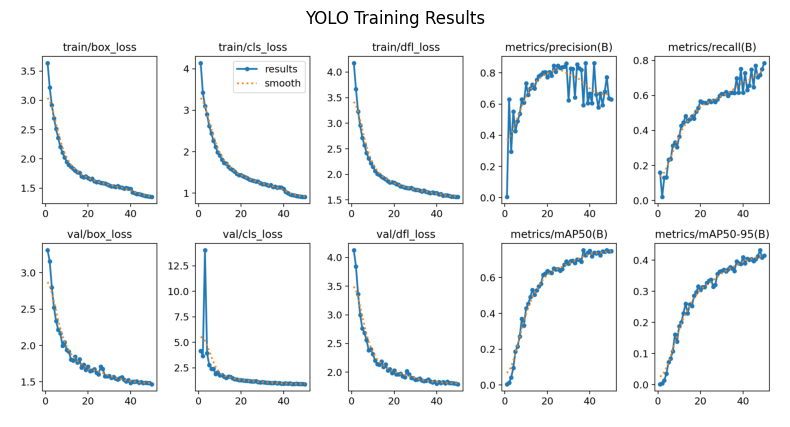

Validating...
Ultralytics 8.3.163 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 117.9±121.2 MB/s, size: 60.7 KB)


val: Scanning /kaggle/input/objects-data/valid/labels... 119 images, 0 backgrounds, 0 corrupt: 100%|██████████| 119/119 [00:00<00:00, 814.84it/s]

WARNING ⚠️ val: Cache directory /kaggle/input/objects-data/valid is not writeable, cache not saved.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.13it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        119        715      0.784      0.713      0.764      0.433
                helmet        117        232      0.847      0.875      0.909      0.499
             no-helmet          6         11      0.816      0.182      0.342      0.187
               no-vest         52         90      0.689      0.711      0.741      0.385
                person        115        241      0.798      0.934      0.931      0.596
                  vest         74        141      0.771      0.865      0.897      0.498
Speed: 2.0ms preprocess, 8.6ms inference, 0.0ms loss, 5.2ms postprocess per image
Results saved to models/yolov8_ppe-v1_20250709_150501/train_run2
mAP50: 0.7640
Model saved to models/yolov8_ppe-v1_20250709_150501/final_model.pt
Best model copied to models/yolov8_ppe-v1_20250709_150501/best_model.pt
Best model path: models/yolov8_ppe-v1_20250709_150501/best_model.pt


In [9]:
# trainer = YOLOTrainer(model_type='yolov8n.yaml', version="ppe-v1")
# trainer.train(data_yaml=dataset.data_yaml, epochs=50, imgsz=640, batch=32)
# trainer.plot_results()
# trainer.validate()
trainer = YOLOTrainer(model_type='yolov8n.yaml', version="ppe-v1")
trainer.train(data_yaml=dataset.data_yaml, epochs=50, imgsz=640, batch=16)
trainer.plot_results()
trainer.validate()
trainer.save_model(name="final_model.pt", save_best=True)
best_model_path = os.path.join(trainer.model_dir, "best_model.pt")
print("Best model path:", best_model_path)

In [10]:
weights_dir = os.path.join(trainer.model_dir, "train_run", "weights")
exporter = ModelExporter(trainer.model, weights_dir)
exporter.to_onnx("ppe_model.onnx")          
exporter.to_torchscript("ppe_model.torchscript")

Exporting to ONNX...
Ultralytics 8.3.163 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.00GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/

PyTorch: starting from 'models/yolov8_ppe-v1_20250709_150501/train_run/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 9, 8400) (6.0 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<1.18.0', 'onnxslim>=0.1.59', 'onnxruntime-gpu'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 11.2s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.59...
ONNX: export success ✅ 13.1s, saved as 'models/yolov8_ppe-v1_20250709_150501/train_run/weights/best.onnx' (11.7 MB)

Export complete (13.3s)
Results saved to /kaggle/working/models/yolov8_ppe-v1_20250709_150501/train_run/weights


Predicting images in: /kaggle/input/objects-data/test/images

image 1/90 /kaggle/input/objects-data/test/images/ppe_0000_jpg.rf.c102a9a7c8dec01565a8f95ff295974c.jpg: 448x640 1 helmet, 1 person, 7.8ms
image 2/90 /kaggle/input/objects-data/test/images/ppe_0004_jpg.rf.c3265071237f64a4f0c3e1bf3048f923.jpg: 640x640 3 helmets, 3 persons, 3 vests, 8.1ms
image 3/90 /kaggle/input/objects-data/test/images/ppe_0008_jpg.rf.356284e8df05dcd239cb91cf53b51c83.jpg: 448x640 5 persons, 3 vests, 6.8ms
image 4/90 /kaggle/input/objects-data/test/images/ppe_0009_jpg.rf.68866a74a26b99495ad80bc41b7a2897.jpg: 384x640 1 helmet, 1 person, 1 vest, 6.8ms
image 5/90 /kaggle/input/objects-data/test/images/ppe_0013_jpg.rf.a88d9ccde80be57995e344d94a033f3a.jpg: 448x640 1 helmet, 1 person, 7.8ms
image 6/90 /kaggle/input/objects-data/test/images/ppe_0014_jpg.rf.6c486303c2cf17986ff64702b0ce0dd7.jpg: 448x640 1 person, 7.3ms
image 7/90 /kaggle/input/objects-data/test/images/ppe_0038_jpg.rf.e542ed77414548742efb104c27af9902.jp

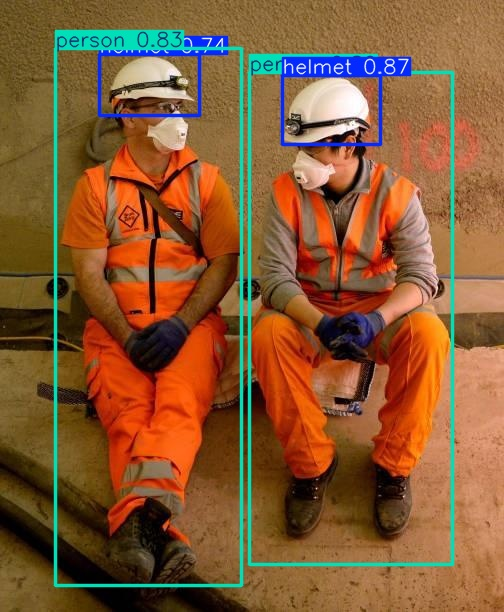

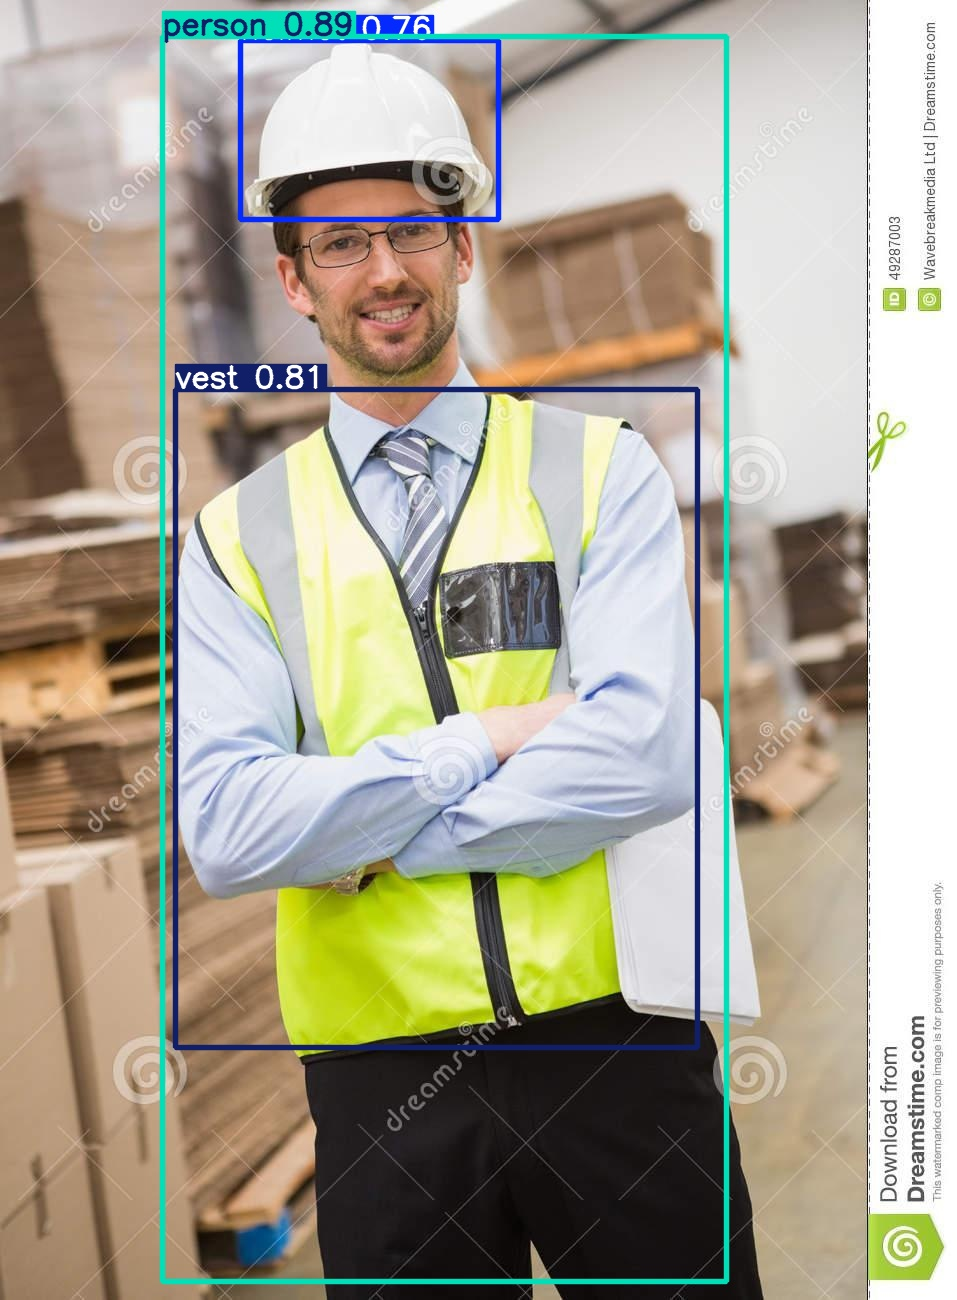

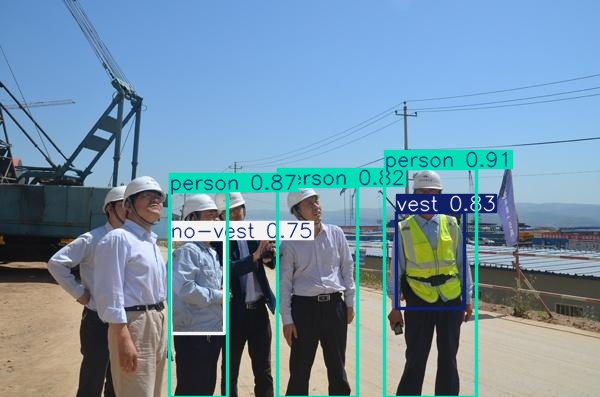

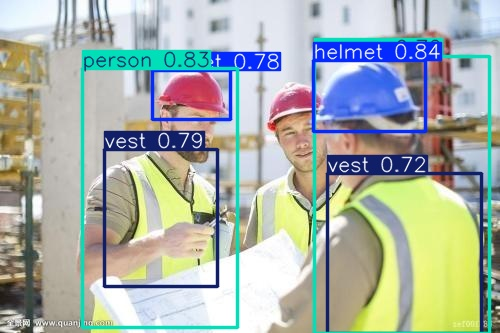

In [22]:
predictor = Predictor(best_model_path)
predictor.predict_images("/kaggle/input/objects-data/test/images")